### This project depicts a fully featured end-to-end Data Science workflow aimed at building models predictive of employee attrition (whether or not an employee leaves a company, in this case: IBM). This project is broken up into a few main parts:

- Data Acquisition 
- Data Cleaning & Pre-Processing
- Exploratory Data Analysis 
- Feature Engineering
- Dataset Preparation (Feature Encoding/Scaling, Train/Test split, etc.)
- Machine Learning Models
- Comparision of Model Results & Best Model Selection 

The tech industry currently has the highest employee turnover rate at 13.2%. Although big tech companies like Google provide great benefits packages and amenities at the office, employees stay at google for an average of 1.1 years. I am hoping that this analysis of employee attrition will help companies look into other variables that may cause employees to leave the company like job involvement, and environment satisfaction. What variables cause employee attrition? 


The dataset used in this analysis is IBM HR Analytics Employee Attrition & Performance. This dataset contains 35 variables that may contribute to employee attrition including, work-life balance, years at the company, age and relationship status. The dataset contains approximately 1470 entries. 

### Imports

In [40]:
# Native
import datetime 
import matplotlib.pyplot as plt 
import os 
import sys

# Non-Native
import numpy as np 
import pandas as pd
import pyspark 
import seaborn as sns
sns.set(style='darkgrid')

#ML Imports
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier

from scipy.stats import ttest_1samp

### Data Acquisition

In [41]:
df = pd.read_csv("attrition.csv")

In [42]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


### Data Cleaning & Pre-Processing

#### Given the dataframe containing the employee data, clean it up by:
- Converting the target variable (Attrition) into a binary variable (0/1)
- Dropping columns that don't appear to be relevant / useful for analysis
- Handing missing / NaN values (in this case, there are none!)


In [43]:
df['Attrition'].replace(to_replace = dict(Yes = 1, No = 0), inplace=True)

### Exploratory Data Analysis 

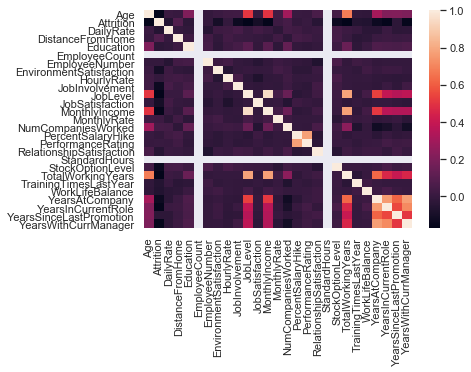

In [44]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

This correlation plot shows that years at the company, years in the current role, years since last promotion and years with the current manager are all correlated with each other. Job level and monthly income are also correlated with these four variables. 

Age is correlated with job level, monthly income, total working years. 

#### Correlation Tests
Tests whether two samples have a linear relationship.

In [45]:
from scipy.stats import pearsonr
stat, p = pearsonr(df['Attrition'], df['Age'])
print('stat= %.3f, p= %.3f' % (stat, p))
if p > 0.05:
    print('Attrition and Age are probably independent')
else:
    print('Attrition and Age are probably dependent')

stat= -0.159, p= 0.000
Attrition and Age are probably dependent


In [46]:
stat, p = pearsonr(df['Attrition'], df['TotalWorkingYears'])
print('stat= %.3f, p= %.3f' % (stat, p))
if p > 0.05:
    print('Attrition and TotalWorkingYears are probably independent')
else:
    print('Attrition and TotalWorkingYears are probably dependent')

stat= -0.171, p= 0.000
Attrition and TotalWorkingYears are probably dependent


In [47]:
stat, p = pearsonr(df['Attrition'], df['JobLevel'])
print('stat= %.3f, p= %.3f' % (stat, p))
if p > 0.05:
    print('Attrition and JobLevel are probably independent')
else:
    print('Attrition and JobLevel are probably dependent')

stat= -0.169, p= 0.000
Attrition and JobLevel are probably dependent


In [48]:
stat, p = pearsonr(df['Attrition'], df['WorkLifeBalance'])
print('stat= %.3f, p= %.3f' % (stat, p))
if p > 0.05:
    print('Attrition and WorkLifeBalance are probably independent')
else:
    print('Attrition and WorkLifeBalance are probably dependent')

stat= -0.064, p= 0.014
Attrition and WorkLifeBalance are probably dependent


#### t-Tests

In [49]:
age = df['Age']
ages_mean = np.mean(age)
print(ages_mean)
tset, pval = ttest_1samp(age, 30)
print('p-values',pval)
if pval < 0.05:    # alpha value is 0.05 or 5%
   print(" we are rejecting null hypothesis")
else:
  print("we are accepting null hypothesis")

36.923809523809524
p-values 4.679915477144685e-147
 we are rejecting null hypothesis


In [50]:
satisfaction = df['JobSatisfaction']
job_satisfaction = np.mean(satisfaction)
print(job_satisfaction)
tset, pval = ttest_1samp(satisfaction, 30)
print('p-values',pval)
if pval < 0.05:    # alpha value is 0.05 or 5%
   print(" we are rejecting null hypothesis")
else:
  print("we are accepting null hypothesis")

2.7285714285714286
p-values 0.0
 we are rejecting null hypothesis


In [51]:
TotalWorkingYears = df['TotalWorkingYears']
working_years = np.mean(TotalWorkingYears)
print(working_years)
tset, pval = ttest_1samp(TotalWorkingYears, 30)
print('p-values',pval)
if pval < 0.05:    # alpha value is 0.05 or 5%
   print(" we are rejecting null hypothesis")
else:
  print("we are accepting null hypothesis")

11.279591836734694
p-values 0.0
 we are rejecting null hypothesis


#### Visualizations 

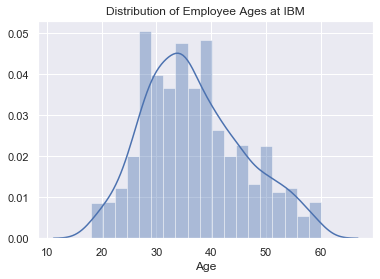

In [52]:
fig, ax = plt.subplots()
ax.set_title('Distribution of Employee Ages at IBM')
sns.distplot(df.Age)

This graph indicates that the average age of Employees at IBM is approximately 35 and is slightly right-skewed indicating that the majority of employees at IBM are young. 

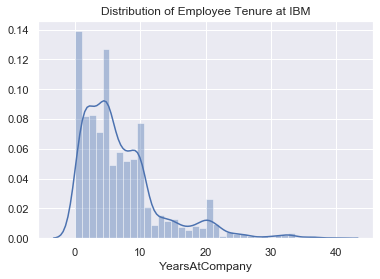

In [53]:
fig, ax = plt.subplots()
ax.set_title('Distribution of Employee Tenure at IBM')
sns.distplot(df.YearsAtCompany)

This graph indicates that the average time spent at IBM is approximately 3 years. 

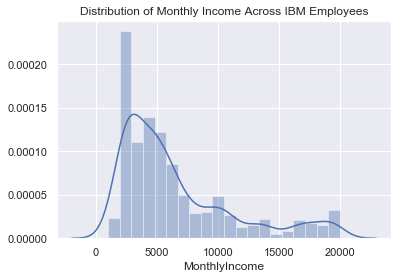

In [54]:
fig, ax = plt.subplots()
ax.set_title('Distribution of Monthly Income Across IBM Employees')
sns.distplot(df.MonthlyIncome)

This graph indicates that the average monthly income is less than 5000 and the graph is right-skewed indicating that the majority of the employees make 5000 or less. 

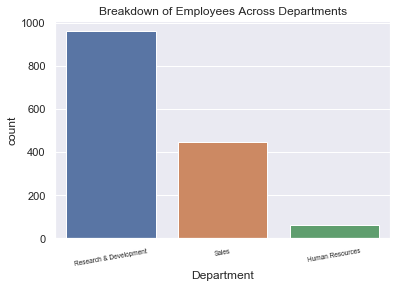

In [55]:
fig, ax = plt.subplots()
ax.set_title('Breakdown of Employees Across Departments')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=6.5, rotation=10)
sns.countplot(df.Department, order=df.Department.value_counts().index)

Around 900 employees work in Research & Development and approximately 400 employees work in Sales with around 70 employees working in Human Resources. 

In [56]:
# Get dataframe where employees left company
attrition_df = df[df['Attrition'] == 1]

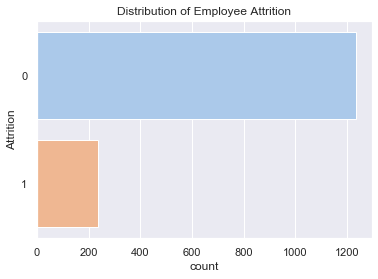

In [57]:
fig, ax = plt.subplots()
ax.set_title('Distribution of Employee Attrition')
sns.countplot(y='Attrition', palette='pastel', data=df)

Around 1200 employees stayed at IBM.

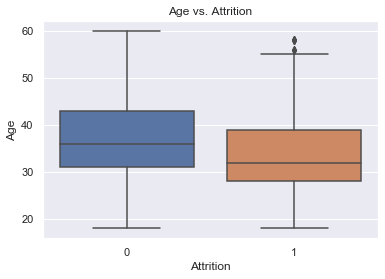

In [58]:
fig, ax = plt.subplots()
ax.set_title('Age vs. Attrition')
sns.boxplot(x='Attrition', y='Age', data=df)

These boxplots show the age distribution of employees that stayed at IBM versus the employees that left. The distribution of employees that left IBM has a mean at approximately  32 years old while the mean of employees that stay is around 36 years old. This shows that younger people are more likely to leave IBM. 

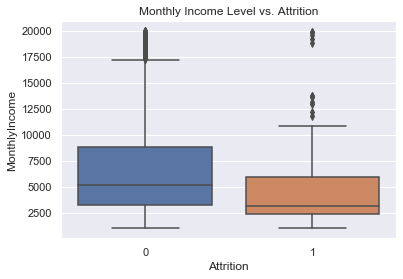

In [59]:
fig, ax = plt.subplots()
ax.set_title('Monthly Income Level vs. Attrition')
sns.boxplot(x='Attrition', y='MonthlyIncome', data=df)

These boxplots show the age distribution of employees that stayed at IBM versus the employees that left. The distribution of employees that left IBM has a mean at approximately  32 years old while the mean of employees that stay is around 36 years old. This shows that younger people are more likely to leave IBM. 

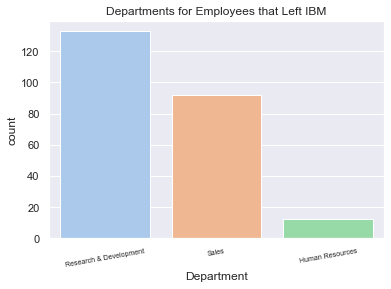

In [60]:
fig, ax = plt.subplots()
  
ax.set_title('Departments for Employees that Left IBM')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7, rotation=10)

sns.countplot(x='Department', palette='pastel', order=attrition_df.Department.value_counts().index, data=attrition_df)

Most of the people who left IBM were in Research and Development at around 140 people, with 90 people in sales and 15 people in Human Resources.

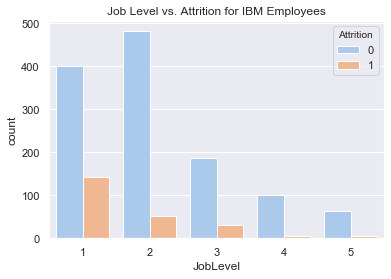

In [61]:
fig, ax = plt.subplots()
ax.set_title('Job Level vs. Attrition for IBM Employees') 
sns.countplot(x='JobLevel', hue='Attrition', palette='pastel', data=df)

This graph shows that entry-level employees are more likely to leave the company than employees at a more senior level. 

### Feature Encoding, Scaling, and Final Data Preparations

In [62]:
def far_distance(df):
  """ Create a variable for employees with a long distance from the place of work. """
  if df['DistanceFromHome'] > 10:
    return  1
  else:
    return 0 

df['far_distance'] = df.apply(lambda df:far_distance(df), axis=1)

def young_no_love(df):
  """ Create a variable for employees that are young and have no relationship obligations :( """
  
  if df['Age'] < 27 and df['MaritalStatus'] == 'Single':
    return 1
  else:
    return 0 
  
df['young_no_love'] = df.apply(lambda df:young_no_love(df), axis=1)

def migrating_worker(df):
  """Create a variable for employees that move around companies often. """
  
  if df['NumCompaniesWorked'] > 3:
    return 1 
  else:
    return 0 

df['migrating_worker'] = df.apply(lambda df:migrating_worker(df), axis=1)

# Compare the adjusted hourly wage with the monthly wage to determine how well compensated an employee is based on time spent in office
df['comp_adjusted'] = df['HourlyRate'] / df['MonthlyRate']

# Create a variable that is a ratio of total monthly income to distance from the work location 
df['distance_comp'] = df['MonthlyIncome'] / df['DistanceFromHome']

In [63]:
def prepare_data(employee_df):
#Make the final preparations to feed our data into our machine learning models. 
# Employee ID Column
    id_employee = ['EmployeeNumber']
# Define our target column, this is our predictor 
    target_column = ['Attrition']
# Handle our categorical variables 
    cols_categorical = employee_df.nunique()[employee_df.nunique() < 15].keys().tolist()
    cols_categorical = [col for col in cols_categorical if col not in target_column]
# Hanlde our numerical columns 
    cols_numerical = [col for col in employee_df.columns if col not in cols_categorical + target_column + id_employee]
# Handle our binary columns 
    cols_binary = employee_df.nunique()[employee_df.nunique() == 2].keys().tolist()
# Handle columns with numerouus values 
    cols_numerous = [col for col in cols_categorical if col not in cols_binary]
# Encode our Binary Columns 
    le = LabelEncoder()
    for col in cols_binary:
        employee_df[col] = le.fit_transform(employee_df[col])
# One-Hot Encoding for Categorical Columns 
    employee_df = pd.get_dummies(data = employee_df, columns = cols_numerous)
    return employee_df 

In [64]:
employee_df = prepare_data(df)

# Define X & Y so we can plug into machine learning models

y = np.array(employee_df.Attrition.tolist())

employee_df.drop(['Attrition'], axis=1, inplace=True)
X = np.array(employee_df.values)

# Feauture Elimation for Features with Low Variance (i.e. if a feature has 0 variance, it's unlikely that there are interesting patterns in the data)
select_crit = VarianceThreshold(threshold=(0.8 * (1-0.8)))
select_crit.fit_transform(X)


# Get the Train / Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=12)

### Machine Learning 

LDA: 0.879052 (0.031583)
KNN: 0.814206 (0.034774)
CART: 0.779039 (0.048753)
NB: 0.750974 (0.046177)
Gboo: 0.858258 (0.027903)
HGB: 0.861452 (0.024033)
XGB: 0.861458 (0.022599)
SVM: 0.839039 (0.031078)
ABoo: 0.861452 (0.033585)
RF: 0.848645 (0.024904)


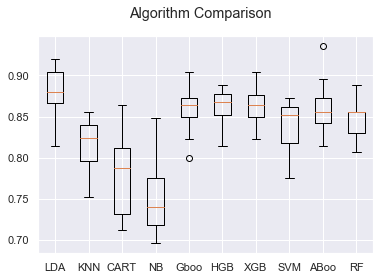

In [65]:
seed = 7
# prepare models
models = []
#models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('Gboo', GradientBoostingClassifier()))
models.append(('HGB', HistGradientBoostingClassifier()))
models.append(('XGB',XGBClassifier()))
models.append(('SVM', SVC()))
models.append(('ABoo', AdaBoostClassifier()))
models.append(('RF', RandomForestClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
msgs = []
predict = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    msgs.append(msg)
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

From the algorithm comparison it looks like the Linear Discriminant Analysis, Hist Gradient Boosting Classifier, and XGB Classifier should be studied more. 

In [66]:
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

#### Confusion Matrix for Linear Discriminant Analysis

Confusion matrix, without normalization
[[182   3]
 [ 21  15]]
Normalized confusion matrix
[[0.98 0.02]
 [0.58 0.42]]


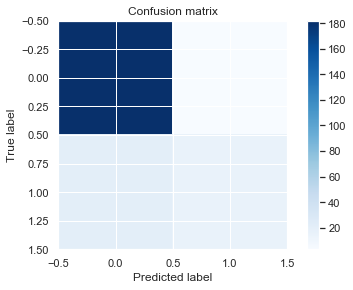

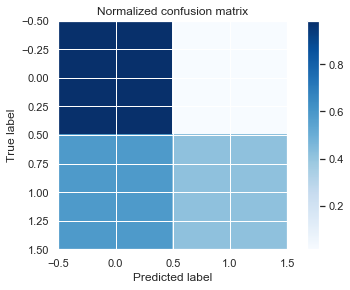

In [71]:
lda = LinearDiscriminantAnalysis()
y_pred = lda.fit(X_train, y_train).predict(X_test)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

#### Confusion Matrix for Hist Gradient Boosting Classifier

Confusion matrix, without normalization
[[181   4]
 [ 26  10]]
Normalized confusion matrix
[[0.98 0.02]
 [0.72 0.28]]


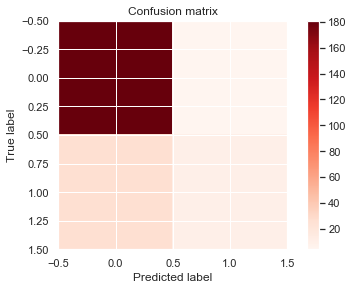

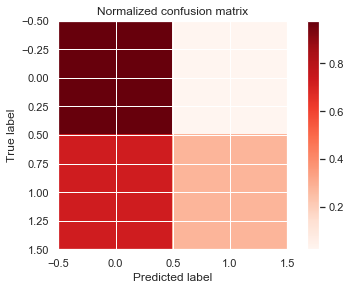

In [74]:
hist = HistGradientBoostingClassifier()
y_pred_hist = hist.fit(X_train, y_train).predict(X_test)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_hist)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)



cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

#### Confusion Matrix for XGB Classifier

Confusion matrix, without normalization
[[182   3]
 [ 24  12]]
Normalized confusion matrix
[[0.98 0.02]
 [0.67 0.33]]


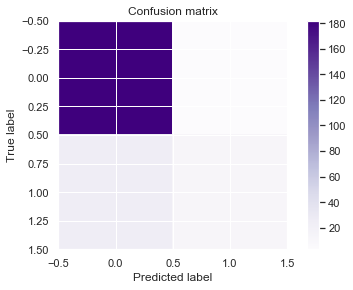

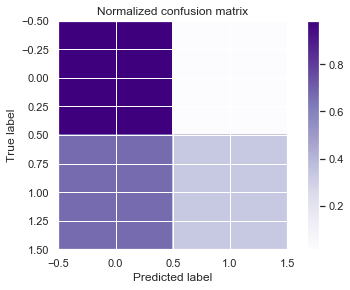

In [75]:
xgb = XGBClassifier()
y_pred_xgb = xgb.fit(X_train, y_train).predict(X_test)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Purples):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)



cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()